<a href="https://colab.research.google.com/github/A1171/ColabNotebooks/blob/main/Timeseria_K_Means_%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%88%D0%B0%D0%B1%D0%BB%D0%BE%D0%BD%D0%B0_%D0%BF%D0%BE%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D1%8F_%D1%86%D0%B5%D0%BD%D1%8B_%D1%87%D0%B5%D1%80%D0%B5%D0%B7_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Предсказание шаблона поведения цены.
1. Классификация шаблонов поведения цены методом K-Mean. 
2. Тренировка нейросети для предсказания шаблона

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Загрузка библиотек

In [2]:
#%tensorflow_version 1.x
import keras
from keras import regularizers
import datetime
from keras import layers
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import RFE
import numpy as np
import tensorflow as tf
!pip install tslearn
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 20.9 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Простая моделька для временного ряда

In [56]:
def ModelConvDense2(Shape1,Neurons,Filters,NumOuts):
  inputs1 = keras.Input(shape=Shape1)
  lambdaActivityDense=0#0.00000003;
  lambdaActivity1=0
  lambdaActivity=0
  l2Conv=0.0005
  l2Dense=0.001
  l2ConvB=0.0005
  l2DenseB=0.001
  x1 = layers.Conv1D(Filters,3, activation='tanh',kernel_regularizer=regularizers.l2(l2Dense),bias_regularizer=regularizers.l2(l2Dense),activity_regularizer=regularizers.l1(lambdaActivity1))(inputs1)
  x1 = layers.Concatenate()([layers.Flatten()(inputs1),layers.Flatten()(x1)])
  x1 = layers.Dense(Neurons, activation='tanh')(x1)
  x1 = layers.Dense(NumOuts, activation='softmax')(x1)
  Model=keras.Model(inputs=inputs1, outputs=x1)
  return Model

Загрузим файл истории, отберем свойства и отмасштабируем их с помощью скользящих средних от mean и std, средние считаем с помощью свертки. Объяснение расчета средних не входит в задачу данного блокнота.
Предсказываем какая будет свеча нарисованная ценой через 1 период

In [8]:
HistoryFileDir="drive/My Drive/NN/DiplShares/"
#Загрузка массива данных и разбивка на выборки
AdditNames=["SBER_M5_Linear5"]
trainPart=0.9
testPart=0.1
x_features=[8,9,10,11,12,15,18,19,21]
y_features=[8,9,10,11]
sequence_length=32
batch_size=4096
x_data_1 = np.loadtxt(HistoryFileDir+"DataFileI1_"+AdditNames[0]+'.txt')
y_data_1 = x_data_1[1:,y_features].copy()#-x_data_1[:-1,y_features[0]].reshape(-1,1).copy()#substract prev close
x_data_1 = x_data_1[:-1,x_features]

Свертка расчет скользящих средних.

In [9]:
import scipy.signal as sps

MALen=sequence_length*5
Filter1=np.ones((MALen,1))/MALen
x_data_mean = sps.fftconvolve(x_data_1, Filter1, mode='valid')
x_data_sub = x_data_1[MALen-1:]-x_data_mean
x_data_sub2 = np.power(x_data_sub,2)
x_data_mean2 = sps.fftconvolve(x_data_sub2, Filter1, mode='valid')
x_data_sub2=x_data_sub2[MALen-1:]
#x_data_mean2=np.power(x_data_mean2,1/2)
x_data_mean=x_data_mean[MALen-1:]
x_data_mean2[x_data_mean2<0.001]=0.001

Проверяем что нет нулей в STD т.к. на нее будем делить

In [10]:
len(x_data_mean2[x_data_mean2<0.001])

0

Масштабируем временной ряд и выходные свечи. из выходной свечи вычитаем Open, т.к. нам нужно предсказывать ее форму, и для предсказания она всегда начинается с 0

In [11]:
x_data_1=(x_data_1[MALen*2-1-1:]-x_data_mean2)/x_data_mean2
y_data_1=(y_data_1[MALen*2-1-1:]-x_data_mean2[:,:4])/x_data_mean2[:,:4]
y_data_1=y_data_1-y_data_1[:,0].reshape(-1,1)

Пример отмасштабированных данных

In [12]:
x_data_1[:3]

array([[20.3355895 , 19.55138369, 21.08181911, 20.13434108, -0.9775371 ,
         4.91469133,  3.68604463,  1.47953481,  6.68731957],
       [19.50761122, 18.80095851, 20.195766  , 19.34109662, -0.9809036 ,
         4.55031145,  3.7182675 ,  1.18131762,  6.07368327],
       [18.75745819, 18.1079549 , 19.39766243, 18.6182511 , -0.96782806,
         5.03160392,  3.69728398,  1.17705245,  5.96533496]])

In [ ]:
y_data_1[:3]

array([[ 0.        , -0.78893135,  0.73860379, -0.21340717],
       [ 0.        , -0.6376877 ,  0.70458459, -0.10783298],
       [ 0.        , -0.65091176,  0.63912188, -0.121521  ]])

Посмотрим как меняется точность кластеризации от числа кластеров

In [ ]:
distortions = []
silhouette = []
kmean_Models = []
K = range(2, 20)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=2, max_iter=10)
    kmeanModel.fit(y_data_1)
    distortions.append(kmeanModel.inertia_)
    kmean_Models.append(kmeanModel)
    if k > 1:
        silhouette.append(silhouette_score(y_data_1[::10], kmeanModel.labels_[::10]))


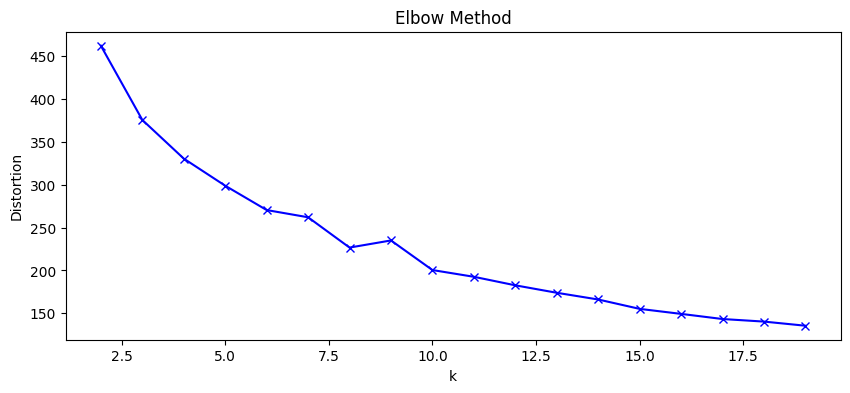

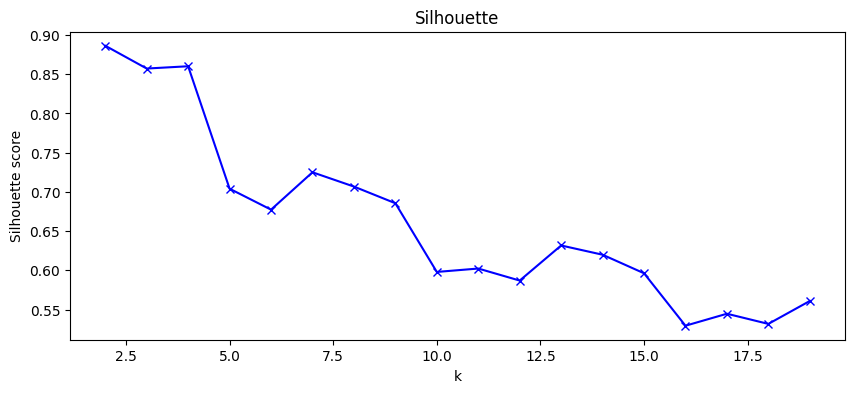

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

Видно что чем больше кластеров тем точнее результат, могли бы отобрать 7, 10, 16 кластеров, ес ли бы не было дальнейшей обработки, но биржевые данные имеют особенность есть много разных нетипичных выбросов, поэтому возьмем 30 кластеров, и самые мелкие объединим в 1 кластер будем считать его выбросами.

In [17]:
#Создадим две модели на 20 и 30 классов
kmeanModel_20 = TimeSeriesKMeans(n_clusters=20, metric="euclidean", n_jobs=3, max_iter=15)
kmeanModel_20.fit(y_data_1)
kmeanModel_30 = TimeSeriesKMeans(n_clusters=30, metric="euclidean", n_jobs=3, max_iter=15)
kmeanModel_30.fit(y_data_1)

TimeSeriesKMeans(max_iter=15, n_clusters=30, n_jobs=3)

In [18]:
#сохраним модели
import pickle
with open('/content/drive/My Drive/NN/'+"kMean_clusters_20.pkl", 'wb') as f: pickle.dump(kmeanModel_20,f)
with open('/content/drive/My Drive/NN/'+"kMean_clusters_30.pkl", 'wb') as f: pickle.dump(kmeanModel_30,f)

In [19]:
#инерция моделей
print(kmeanModel_20.inertia_)
print(kmeanModel_30.inertia_)

127.96795735119541
98.1633051213811


In [115]:
#дальше работаем с моделью на 30 кластеров посчитаем размер каждого кластера и пометим самые мелкие, размером ниже 4% от выборки
n_clusters=30
Y_train_predict_cluster=np.array(kmeanModel_30.predict(y_data_1))определим класс для каждой выходной свечи
Y_cluster_entryes=np.zeros(n_clusters,dtype=int)посчитаем количество объектов каждого класса
for i in Y_train_predict_cluster:
  Y_cluster_entryes[i]=Y_cluster_entryes[i]+1
MinBorder=0.04
Y_UseCluster=Y_cluster_entryes>np.sum(Y_cluster_entryes)/n_clusters*MinBorderОпределим классы с малым количеством свечей

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 346109 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Размеры кластеров

In [116]:
Y_cluster_entryes

array([246395,   8368,   5228,    625,     27,    504,   1364,   1077,
         7291,    237,     78,     20,    135,     23,    171,   2070,
         5319,   1755,     27,     78,   2596,     14,     37,  36129,
            2,     38,    127,    158,   1411,  24805])

False - мелкие кластера

In [117]:
Y_UseCluster

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
       False, False, False, False, False, False,  True,  True,  True,
       False, False,  True, False, False,  True, False, False, False,
       False,  True,  True])

лист с мелкими кластерами

In [118]:
LittleClusterList=[]
for i in range(len(Y_UseCluster)):
  if(Y_UseCluster[i]==False):
    LittleClusterList.append(i)

In [119]:
LittleClusterList

[4, 9, 10, 11, 12, 13, 14, 18, 19, 21, 22, 24, 25, 26, 27]

Заменим номера всех мелких  кластеров на один и тот же номер

In [120]:
LittleClustersPos=LittleClusterList[0]
Y_train_predict_cluster2=Y_train_predict_cluster.copy()
for i in LittleClusterList:
  Y_train_predict_cluster2[Y_train_predict_cluster2==i]=LittleClustersPos

Пересчитаем количество кластеров, мелкие теперь объединены в один.

In [121]:
Y_cluster_entryes2=np.zeros(n_clusters,dtype=int)
for i in Y_train_predict_cluster2:
  Y_cluster_entryes2[i]=Y_cluster_entryes2[i]+1
Y_UseCluster2=Y_UseCluster.copy()
Y_UseCluster2[LittleClustersPos]=True

In [122]:
Y_cluster_entryes2

array([246395,   8368,   5228,    625,   1172,    504,   1364,   1077,
         7291,      0,      0,      0,      0,      0,      0,   2070,
         5319,   1755,      0,      0,   2596,      0,      0,  36129,
            0,      0,      0,      0,   1411,  24805])

Нарисуем центроиды кластеров

In [128]:
width=0.4

def plot_cluster_center(cluster_center):
    fig, ax = plt.subplots(
        int(np.ceil((cluster_center.shape[0])/6)),
        6,
        figsize=(20, 3*int(np.ceil((cluster_center.shape[0])/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, row in enumerate(cluster_center):#.iterrows()
        #row[:,4]=row[:,4]/5
        #ax[index].plot(row[:,0:4])
        ax[index].set_title(f"{index}")
        plt.xticks(rotation=45)
        
        OPEN=row[0, 0].reshape(-1,1)
        HIGH=row[1, 0].reshape(-1,1)
        LOW=row[2, 0].reshape(-1,1)
        CLOSE=row[3, 0].reshape(-1,1)
        N=1
        #print(OPEN,HIGH,LOW,CLOSE)
        UpBar=np.zeros((N))
        DnBar=np.zeros((N))
        Bottom=np.zeros((N))
        for i in range(N):
          DnBar[i]=OPEN[i]-CLOSE[i] if OPEN[i]>CLOSE[i] else 0
          UpBar[i]=CLOSE[i]-OPEN[i] if OPEN[i]<CLOSE[i] else 0
          Bottom[i]=OPEN[i] if OPEN[i]<CLOSE[i] else CLOSE[i]
        #print(DnBar,UpBar,Bottom,HIGH[0]-LOW[0])
        p1 = ax[index].bar(i, DnBar, width,bottom=Bottom, yerr=0.0, label='Women',color='red')
        p2 = ax[index].bar(i, UpBar, width,bottom=Bottom, yerr=0.0, label='Women',color='green')
        p3 = ax[index].bar(i, HIGH[0]-LOW[0], width/4,bottom=LOW[0], yerr=0.0, label='Women',color='black')
        ax[index].set_title(f"Cluster={index} "+str(ClassesCount[index]))# Samples={cluster_entryes[index]}")
    plt.tight_layout()
    plt.show()

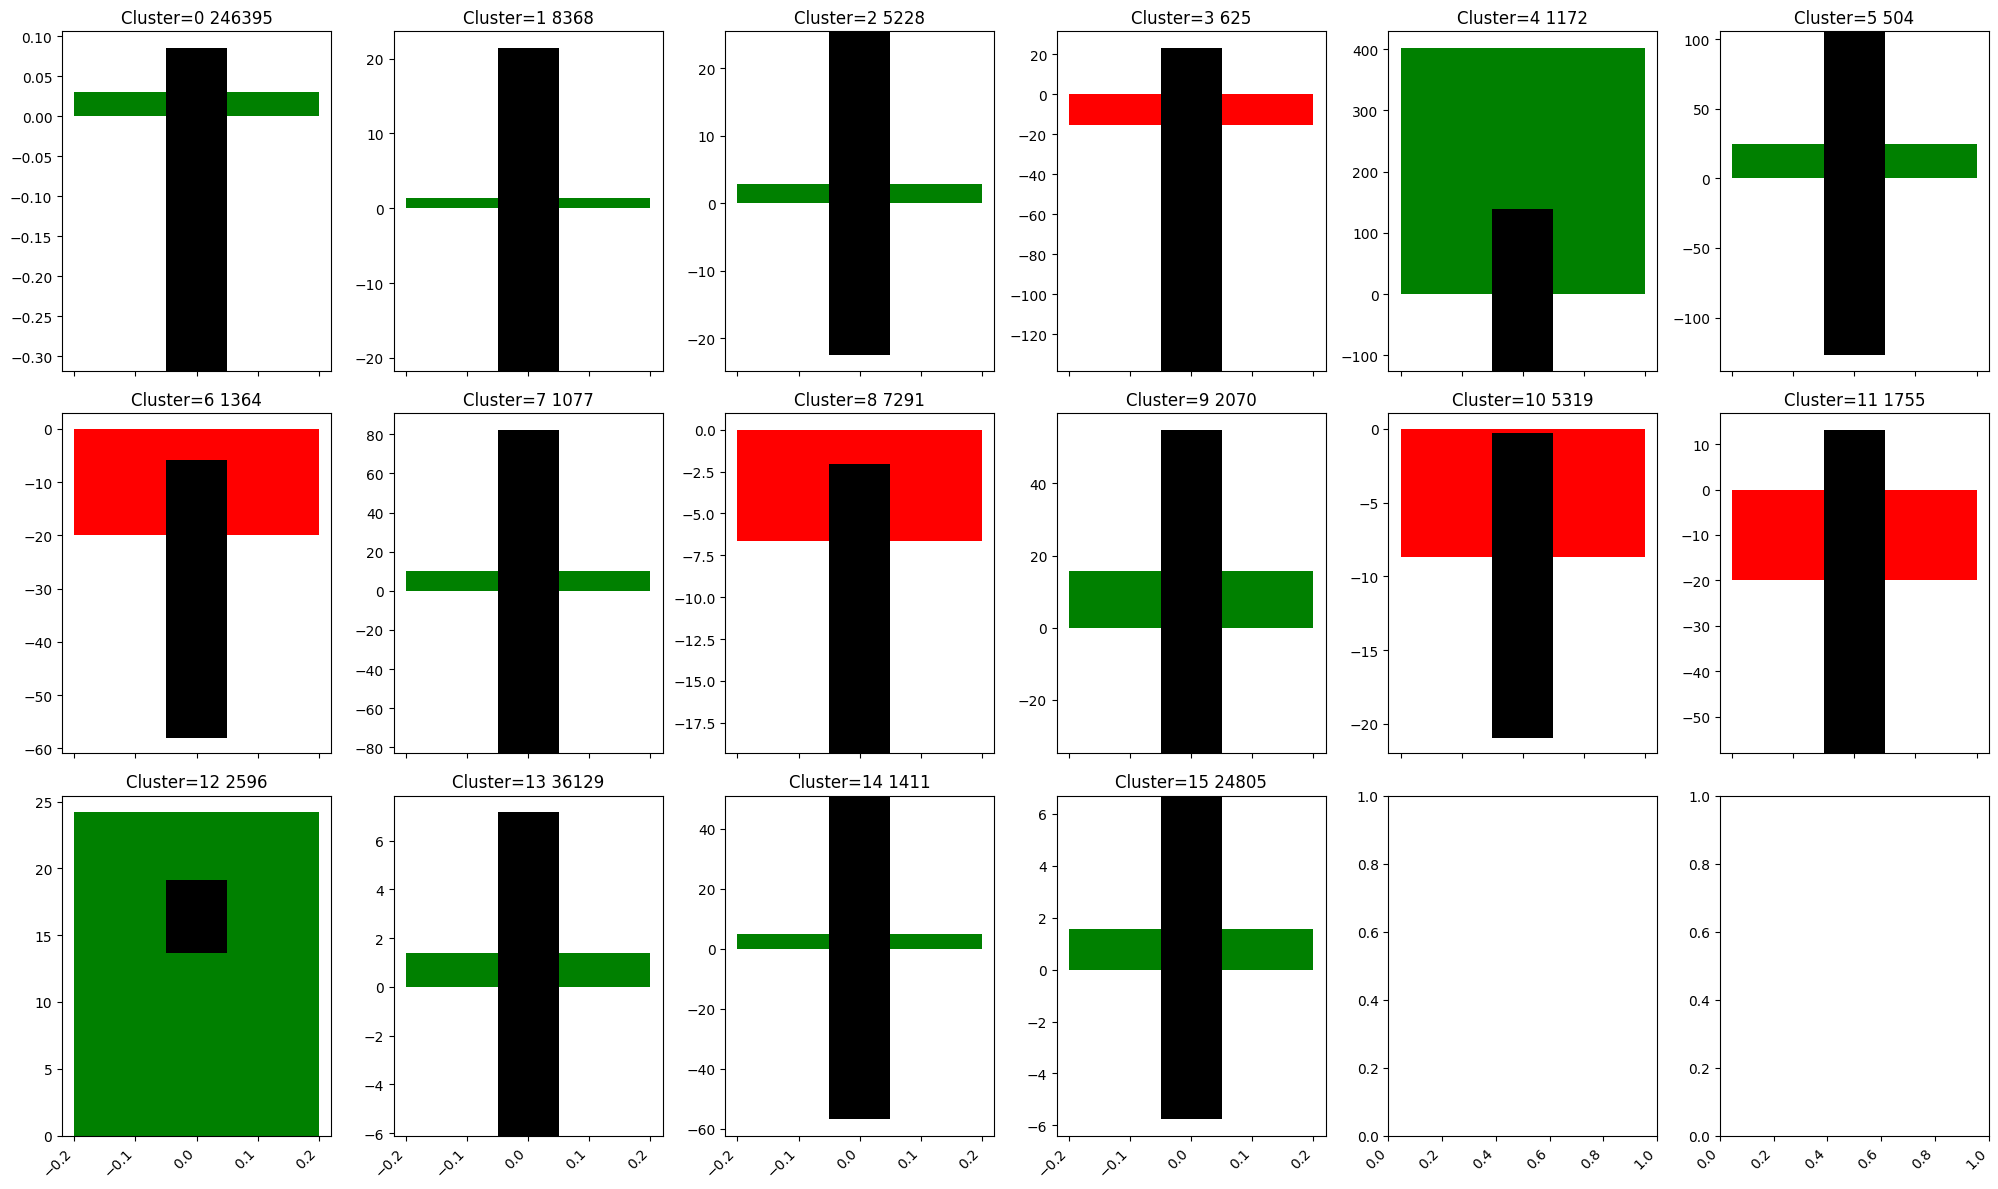

In [129]:
plot_cluster_center(kmeanModel_30.cluster_centers_[Y_UseCluster2])

прогоним номер кластера через биналайзер для создания массива OHE для обучения

In [123]:
OutBinalizer=preprocessing.LabelBinarizer()
OutBinalizer.fit(Y_train_predict_cluster2)
y_data_after_bin=OutBinalizer.transform(Y_train_predict_cluster2)


In [124]:
ClassesCount=np.sum(y_data_after_bin,axis=0)
ClassesCount

array([246395,   8368,   5228,    625,   1172,    504,   1364,   1077,
         7291,   2070,   5319,   1755,   2596,  36129,   1411,  24805])

Матрица весов для балансировки классов

In [61]:
WeightMatrix=np.amax(ClassesCount)/ClassesCount
Multiplier=len(WeightMatrix)/np.sum(WeightMatrix)
WeightMatrix=WeightMatrix*Multiplier
WeightMatrix=dict(enumerate(WeightMatrix.flatten(), 0))
WeightMatrix

{0: 0.007252364160897179,
 1: 0.21354520404209615,
 2: 0.34180303508497717,
 3: 2.859114027878817,
 4: 1.5246981803961268,
 5: 3.5455283083814693,
 6: 1.3100779086688128,
 7: 1.6591887348414676,
 8: 0.24508932484216986,
 9: 0.8632590663885316,
 10: 0.33595530502430165,
 11: 1.018203001381345,
 12: 0.6883460198090372,
 13: 0.049460164062782266,
 14: 1.2664395942057125,
 15: 0.07203976083145577}

датасеты с временными последовательностями

In [44]:
trainPart=0.9
sequence_length=32
dataset_tr = tf.keras.utils.timeseries_dataset_from_array(x_data_1[:int(len(x_data_1)*trainPart)], y_data_after_bin[:int(len(x_data_1)*trainPart)], sequence_length=sequence_length,batch_size=batch_size)
dataset_test = tf.keras.utils.timeseries_dataset_from_array(x_data_1[int(len(x_data_1)*trainPart):], y_data_after_bin[int(len(x_data_1)*trainPart):], sequence_length=sequence_length,batch_size=batch_size)


Определим форму входа и выхода

In [49]:
for batch in dataset_tr:
  In1,Out1=batch
  InShape=In1.shape
  OutShape=Out1.shape
  break

In [51]:
adamopt=tf.keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.9, beta_2=0.999, amsgrad=False)

Создадим модель.

In [57]:
Model=ModelConvDense2(InShape[1:],50,32,Out1.shape[1])

In [60]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 9)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 30, 32)       896         ['input_2[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 288)          0           ['input_2[0][0]']                
                                                                                                  
 flatten_3 (Flatten)            (None, 960)          0           ['conv1d_1[0][0]']               
                                                                                              

In [62]:
Model.compile(loss="categorical_crossentropy",optimizer=adamopt,metrics=['accuracy','mae'])#"mse"
history1=Model.fit(dataset_tr,validation_data=dataset_test,class_weight=WeightMatrix,epochs=15,verbose=1)#


Epoch 1/15
77/77 [==============================] - 46s 486ms/step - loss: 0.2469 - accuracy: 0.4103 - mae: 0.0967 - val_loss: 1.5085 - val_accuracy: 0.5880 - val_mae: 0.0758
Epoch 2/15
77/77 [==============================] - 34s 435ms/step - loss: 0.2297 - accuracy: 0.6071 - mae: 0.0778 - val_loss: 1.4829 - val_accuracy: 0.6395 - val_mae: 0.0750
Epoch 3/15
77/77 [==============================] - 34s 435ms/step - loss: 0.2252 - accuracy: 0.5887 - mae: 0.0780 - val_loss: 1.4979 - val_accuracy: 0.5938 - val_mae: 0.0726
Epoch 4/15
77/77 [==============================] - 34s 437ms/step - loss: 0.2212 - accuracy: 0.5850 - mae: 0.0767 - val_loss: 1.5812 - val_accuracy: 0.5319 - val_mae: 0.0748
Epoch 5/15
77/77 [==============================] - 35s 454ms/step - loss: 0.2164 - accuracy: 0.5914 - mae: 0.0771 - val_loss: 1.3928 - val_accuracy: 0.5976 - val_mae: 0.0665
Epoch 6/15
77/77 [==============================] - 33s 434ms/step - loss: 0.2137 - accuracy: 0.5949 - mae: 0.0761 - val_loss

Матрица классификации

In [133]:
#Y_prd=[]
#X_prd=[]
ClassificationMatrix=np.zeros((OutShape[-1],OutShape[-1]))
for Batch in dataset_test:
  X,Y=Batch
  prd=Model.predict(X)
  for j in range(len(prd)):
    ClassificationMatrix[np.argmax(prd[j]),np.argmax(Y[j])]+=1

57/57 [==============================] - 0s 2ms/step


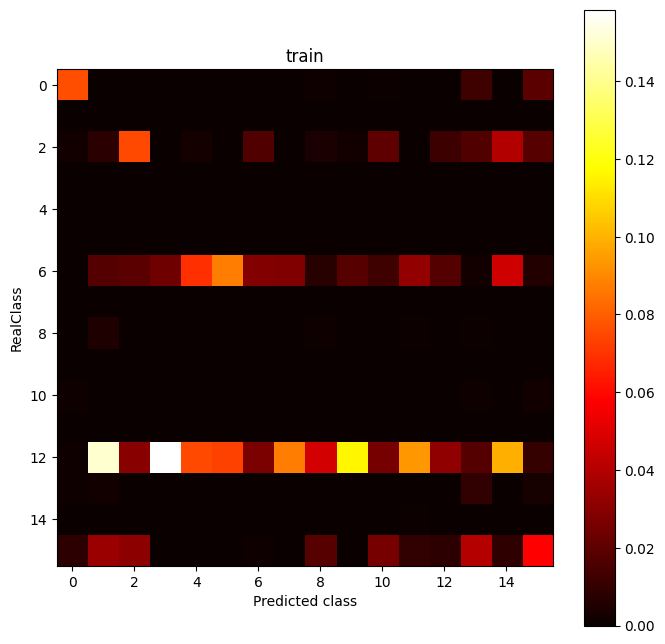

In [143]:
#матрица классификации для тестовой выборки
plt.figure(figsize=(8,8))
plt.imshow(ClassificationMatrix/ClassesCount, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xlabel("Predicted class")
plt.ylabel("RealClass")
plt.title('train')
plt.show()


Чаще всего определяет 6 и 12 классы, квадраты по диагонали прослеживаются слабо.
Метод предсказания кластера поведени цены показал себя неудачно. Вероятно можно доработать, но разбивка на шаблоны во время парсинга дает лучшие результаты. Метод интересен в ознакомительных целях.